 `Cifar`、`MNIST` 等常用数据集的坑：
- 每次在一台新的机器上使用它们去训练模型都需要重新下载（国内网络往往都不给力，需要花费大量的时间，有时还下载不了）；
- 即使下载到本地，然而不同的模型对它们的处理方式各不相同，我们又需要花费一些时间去了解如何读取数据。

为了解决上述的坑，我在[Bunch 转换为 HDF5 文件：高效存储 Cifar 等数据集](http://www.cnblogs.com/q735613050/p/9244223.html)中将一些常用的数据集封装为 `HDF5` 文件。

下面的 `X.h5c` 可以参考[Bunch 转换为 HDF5 文件：高效存储 Cifar 等数据集](http://www.cnblogs.com/q735613050/p/9244223.html)自己制作，也可以直接下载使用（链接：https://pan.baidu.com/s/1hsbMhv3MDlOES3UDDmOQiw 密码：qlb7）。

使用方法很简单：

# 访问数据集

In [1]:
# 载入所需要的包
import tables as tb
import numpy as np

In [2]:
xpath = 'E:/xdata/X.h5'  # 文件所在路径
h5 = tb.open_file(xpath)

下面我们来看看此文件中有那些数据集：

In [3]:
h5.root

/ (RootGroup) "Xinet's dataset"
  children := ['cifar10' (Group), 'cifar100' (Group), 'fashion_mnist' (Group), 'mnist' (Group)]

下面我们以 `Cifar` 为例，来详细说明该文件的使用：

In [4]:
cifar = h5.root.cifar100   # 获取 cifar100

为了高效使用数据集，我们使用迭代器的方式来获取它：

In [5]:
class Loader:
    """
    方法
    ========
    L 为该类的实例
    len(L)::返回 batch 的批数
    iter(L)::即为数据迭代器

    Return
    ========
    可迭代对象（numpy 对象）
    """

    def __init__(self, X, Y, batch_size, shuffle):
        '''
        X, Y 均为类 numpy 
        '''
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        n = len(self.X)
        idx = np.arange(n)

        if self.shuffle:
            np.random.shuffle(idx)

        for k in range(0, n, self.batch_size):
            K = idx[k:min(k + self.batch_size, n)].tolist()
            yield np.take(self.X, K, 0), np.take(self.Y, K, 0)

    def __len__(self):
        return round(len(self.X) / self.batch_size)

下面我们可以使用 `Loader` 来实例化我们的数据集：

In [6]:
batch_size = 512
train_cifar = Loader(cifar.trainX, cifar.train_fine_labels, batch_size, True)
test_cifar = Loader(cifar.testX, cifar.test_fine_labels, batch_size, False)

读取一个 Batch 的数据：

In [7]:
for imgs, labels in iter(train_cifar):
    break

In [8]:
names = np.asanyarray([cifar.fine_label_names[label] for label in labels], dtype='U')
names[:7]

array(['orchid', 'spider', 'rabbit', 'shark', 'shrew', 'clock', 'bed'],
      dtype='<U13')

# 可视化

需要注意，这里的 `Cifar` 是 `first channel` 的，即：

In [9]:
imgs.shape

(512, 3, 32, 32)

In [10]:
names.shape

(512,)

In [11]:
from pylab import plt, mpl


mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号 '-' 显示为方块的问题


def show_imgs(imgs, labels):
    '''
    展示 多张图片
    '''
    imgs = np.transpose(imgs, (0, 2, 3, 1))
    n = imgs.shape[0]
    h, w = 5, int(n / 5)
    fig, ax = plt.subplots(h, w, figsize=(7, 7))
    K = np.arange(n).reshape((h, w))
    names = np.asanyarray([cifar.fine_label_names[label] for label in labels], dtype='U')
    names = names.reshape((h, w))
    for i in range(h):
        for j in range(w):
            img = imgs[K[i, j]]
            ax[i][j].imshow(img)
            ax[i][j].axes.get_yaxis().set_visible(False)
            ax[i][j].axes.set_xlabel(names[i][j])
            ax[i][j].set_xticks([])
    plt.show()

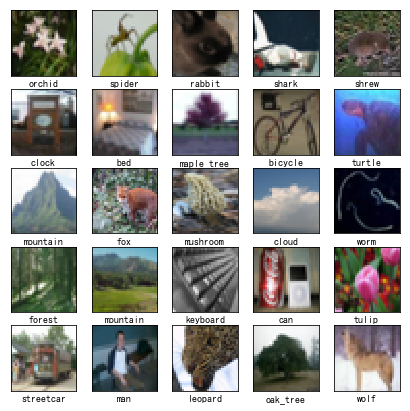

In [12]:
show_imgs(imgs[:25], labels[:25])

# $2$ 个深度学习框架 & 数据集

因为，上面的数据集是 `NumPy` 的 `array` 形式，故而：

## TensorFlow 

In [13]:
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
for imgs, labels in iter(train_cifar):
    imgs = tf.constant(imgs)
    labels = tf.constant(labels)
    break

In [15]:
imgs

<tf.Tensor 'Const:0' shape=(512, 3, 32, 32) dtype=uint8>

In [16]:
labels

<tf.Tensor 'Const_1:0' shape=(512,) dtype=int32>

## MXNet

In [17]:
from mxnet import nd, cpu, gpu

In [18]:
for imgs, labels in iter(train_cifar):
    imgs = nd.array(imgs, ctx = gpu(0))
    labels = nd.array(labels, ctx = cpu(0))
    break

In [24]:
imgs.context

gpu(0)

In [23]:
labels.context

cpu(0)

# Matlab 读取 HDF
参考：[h5read](https://ww2.mathworks.cn/help/matlab/ref/h5read.html)